In [1]:
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
FOLDERNAME = 'Colab\ Notebooks/stock_predict_1/train1'
%cd drive/MyDrive/$FOLDERNAME
from model_pytorch import train, predict

/content/drive/MyDrive/Colab Notebooks/stock_predict_1/train1


LABEL: (2437, 1)
train_x_len: 2406
train_y_len: 2406
[ 2022/03/16 03:23:40 ] Epoch 0/10
[ 2022/03/16 03:23:47 ] The train loss is 0.183674. The valid loss is 0.063425.
[ 2022/03/16 03:23:47 ] Epoch 1/10
[ 2022/03/16 03:23:57 ] The train loss is 0.058579. The valid loss is 0.050375.
[ 2022/03/16 03:23:57 ] Epoch 2/10
[ 2022/03/16 03:24:07 ] The train loss is 0.049258. The valid loss is 0.043510.
[ 2022/03/16 03:24:07 ] Epoch 3/10
[ 2022/03/16 03:24:12 ] The train loss is 0.043897. The valid loss is 0.037823.
[ 2022/03/16 03:24:12 ] Epoch 4/10
[ 2022/03/16 03:24:15 ] The train loss is 0.040799. The valid loss is 0.033612.
[ 2022/03/16 03:24:15 ] Epoch 5/10
[ 2022/03/16 03:24:19 ] The train loss is 0.038422. The valid loss is 0.031691.
[ 2022/03/16 03:24:19 ] Epoch 6/10
[ 2022/03/16 03:24:22 ] The train loss is 0.035822. The valid loss is 0.030017.
[ 2022/03/16 03:24:22 ] Epoch 7/10
[ 2022/03/16 03:24:25 ] The train loss is 0.034429. The valid loss is 0.029525.
[ 2022/03/16 03:24:25 ] Epo

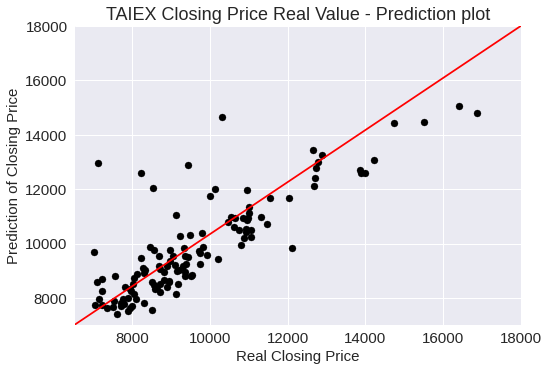

[ 2022/03/16 03:24:34 ] The mean squared error of stock ['Close'] is [0.01332538]
[ 2022/03/16 03:24:34 ] The predicted stock Close for the next 5 day(s) is: 10509.083376178503


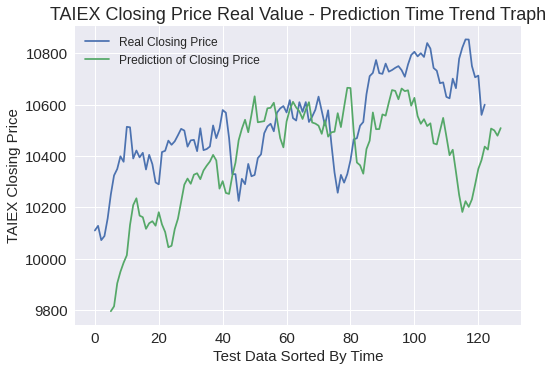

In [3]:
import pandas as pd
import numpy as np
import os
import sys
import time
import logging
from logging.handlers import RotatingFileHandler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
plt.style.use('seaborn')
import matplotlib.lines as mlines

frame = "pytorch"  

class Config:
    # 數據參數
    feature_columns = list(range(2, 14))         # 要作為feature的columns，按原資料從0開始計算，也可以用list 如 [2,4,6,8] 設置
    label_columns = [7]                  # 要預測的columns，按原資料從0開始計算, 預測第12列 收盤價

    label_in_feature_index = (lambda x,y: [x.index(i) for i in y])(feature_columns, label_columns)  # 因為feature不一定從0開始

    predict_day = 5            # 預測未來幾天

    # 網路參數
    input_size = len(feature_columns)
    output_size = len(label_columns)

    hidden_size = 128           # LSTM的隱藏層大小，也是輸出大小
    lstm_layers = 2            # LSTM的堆疊層數
    dropout_rate = 0.2           # dropout概率
    time_step = 30             # 這個參數很重要，是設置用前多少天的資料來預測，也是LSTM的time step數，請保證訓練資料量大於它

    # 訓練參數
    do_train = True
    do_predict = True
    do_val_predict = True         # 用val值預測作QQ圖
    add_train = False           # 是否載入已有模型參數進行增量訓練
    shuffle_train_data = True       # 是否對訓練資料做shuffle
    use_cuda = False            # 是否使用GPU訓練

    train_data_rate = 0.95      # 訓練資料占總體資料比例，測試資料就是 1-train_data_rate
    valid_data_rate = 0.05      # 驗證資料占訓練資料比例，驗證集在訓練過程使用，為了做模型和參數選擇

    random_test_section = True    #隨機取test區段

    batch_size = 32
    learning_rate = 0.001
    epoch = 10                 # 整個訓練集被訓練多少遍，不考慮早停的前提下
    patience = 5                # 訓練多少epoch，驗證集沒提升就停掉
    random_seed = 0            # 隨機種子，保證可複現

    do_continue_train = False     # 每次訓練把上一次的final_state作為下一次的init_state，僅用於RNN類型模型，目前僅支援pytorch
    continue_flag = ""            # 但實際效果不佳，可能原因：僅能以 batch_size = 1 訓練
    if do_continue_train:
        shuffle_train_data = False
        batch_size = 1
        continue_flag = "continue_"

    # 訓練模式
    debug_mode = False  # 調試模式下，是為了跑通代碼，追求快
    debug_num = 500  # 僅用debug_num條數據來調試

    # 框架參數
    used_frame = frame  # 選擇的深度學習框架，不同的框架模型保存尾碼不一樣
    model_postfix = {"pytorch": ".pth", "keras": ".h5", "tensorflow": ".ckpt"}
    model_name = "model_" + continue_flag + used_frame + model_postfix[used_frame]

    # 路徑參數
    train_data_path = "/content/drive/MyDrive/Colab Notebooks/stock_predict/train1/data/data_set(0616)_0619.csv"
    model_save_path = "/content/drive/MyDrive/Colab Notebooks/stock_predict/train1/save/model_pytorch.py"
    figure_save_path = "/content/drive/MyDrive/Colab Notebooks/stock_predict/train1/save/figure"
    log_save_path = "/content/drive/MyDrive/Colab Notebooks/stock_predict/train1/save/"
    do_log_print_to_screen = True
    do_log_save_to_file = False                  ## 是否將config和訓練過程記錄到log
    do_figure_save = False
    do_train_visualized = False          # 訓練loss視覺化，pytorch用visdom，tf用tensorboardX，實際上可以通用, keras沒有
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)    # makedirs 遞迴創建目錄
    if not os.path.exists(figure_save_path):
        os.mkdir(figure_save_path)
    if do_train and (do_log_save_to_file or do_train_visualized):
        cur_time = time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())
        log_save_path = log_save_path + cur_time + '_' + used_frame + "/"
        os.makedirs(log_save_path)

class Data:
    def __init__(self, config):
        self.config = config
        self.data, self.data_column_name = self.read_data()

        self.data_num = self.data.shape[0]
        self.train_num = int(self.data_num * self.config.train_data_rate)

        self.mean = np.mean(self.data, axis=0)               # 資料的均值和方差
        self.std = np.std(self.data, axis=0)
        self.norm_data = (self.data - self.mean)/self.std   # 歸一化，去量綱

        self.start_num_in_test = 0      # 測試集中前幾天的資料會被刪掉，因為它不夠一個time_step

        import random                 #random test需要
        random.seed(0)
        self.r_test_start = random.randint(0, self.norm_data.shape[0])
        self.r_test_end = self.r_test_start + int((1-self.config.train_data_rate)*self.norm_data.shape[0])

    def read_data(self):                # 讀取初始數據
        if self.config.debug_mode:
            init_data = pd.read_csv(self.config.train_data_path, nrows=self.config.debug_num,
                                    usecols=self.config.feature_columns)
        else:
            init_data = pd.read_csv(self.config.train_data_path, usecols=self.config.feature_columns)
        return init_data.values, init_data.columns.tolist()     # .columns.tolist() 是獲取列名

    def get_train_and_valid_data(self):
        feature_data = self.norm_data[:self.train_num]
        label_data = self.norm_data[self.config.predict_day : self.config.predict_day + self.train_num,
                                    self.config.label_in_feature_index]    # 將延後幾天的資料作為label
       
        if not self.config.do_continue_train:
             # 在非連續訓練模式下，每time_step行資料會作為一個樣本，兩個樣本錯開一行，比如：1-20行，2-21行。。。。

            train_x = [feature_data[i:i+self.config.time_step] for i in range(self.train_num-self.config.time_step)]
            train_y = [label_data[i+self.config.time_step] for i in range(self.train_num-self.config.time_step)]
           
        else:
            train_x = [feature_data[start_index + i*self.config.time_step : start_index + (i+1)*self.config.time_step]
                       for start_index in range(self.config.time_step)
                       for i in range((self.train_num - start_index) // self.config.time_step)]
            train_y = [label_data[start_index + i*self.config.time_step : start_index + (i+1)*self.config.time_step]
                       for start_index in range(self.config.time_step)
                       for i in range((self.train_num - start_index) // self.config.time_step)]
        train_x, train_y = np.array(train_x), np.array(train_y)
        train_y = np.expand_dims(train_y,1).repeat(self.config.time_step,axis=1)  #增維並複製

        train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=self.config.valid_data_rate,
                                                              random_state=self.config.random_seed,
                                                              shuffle=self.config.shuffle_train_data)   # 劃分訓練和驗證集，並打亂
        return train_x, valid_x, train_y, valid_y

    def get_test_data(self, return_label_data=False):
        # feature_data = self.norm_data[self.train_num+20:]

        feature_data = self.norm_data[self.train_num-self.config.time_step:]
        # print('feature_data_test:',feature_data.shape)
        sample_interval = min(feature_data.shape[0], self.config.time_step)     # 防止time_step大於測試集數量

        self.num_in_test = feature_data.shape[0] - self.config.predict_day - sample_interval + 1  # 扣掉最後沒有label資料的

        test_x = [feature_data[i:sample_interval+i] for i in range(self.num_in_test)]


        if return_label_data:       # 實際應用中的測試集是沒有label資料的
            label_data = feature_data[sample_interval+self.config.predict_day-1:, self.config.label_in_feature_index]

            return np.array(test_x), label_data
        return np.array(test_x)
    
    def get_test_data_ramdom(self, return_label_data=False):

        feature_data = self.norm_data[self.r_test_start-self.config.time_step:self.r_test_end]
      
        sample_interval = min(feature_data.shape[0], self.config.time_step)     # 防止time_step大於測試集數量
        self.num_in_test = feature_data.shape[0] - self.config.predict_day - sample_interval + 1  # 扣掉最後沒有label資料的
    
        test_x = [feature_data[i:sample_interval+i] for i in range(self.num_in_test)]


        if return_label_data:       # 實際應用中的測試集是沒有label資料的
            label_data = feature_data[sample_interval+self.config.predict_day-1:, self.config.label_in_feature_index]
            return np.array(test_x), label_data
        return np.array(test_x)

    def get_train_and_valid_data_with_ramdom_test(self, return_label_data=False):
        first_half_data = self.norm_data[:self.r_test_start]
        second_half_data = self.norm_data[self.r_test_end:]

        feature_data = np.concatenate((first_half_data,second_half_data),axis=0)
        # feature_data = np.delete(self.norm_data, slice(self.r_test_start,self.r_test_end))
        first_label_data = self.norm_data[self.config.predict_day : self.config.predict_day + self.r_test_start,self.config.label_in_feature_index]
        second_label_data = self.norm_data[self.r_test_end:,self.config.label_in_feature_index]

        label_data = np.concatenate((first_label_data,second_label_data),axis=0)
        # label_data = self.norm_data[self.config.predict_day : self.config.predict_day + self.train_num, 
                                    # self.config.label_in_feature_index]    # 將延後幾天的資料作為label
        
        print('LABEL:',label_data.shape)
        if not self.config.do_continue_train:
             # 在非連續訓練模式下，每time_step行資料會作為一個樣本，兩個樣本錯開一行，比如：1-20行，2-21行。。。。

            train_x = [feature_data[i:i+self.config.time_step] for i in range(self.train_num-self.config.time_step)]
            train_y = [label_data[i+self.config.time_step] for i in range(self.train_num-self.config.time_step)]
            print('train_x_len:',len(train_x))
            print('train_y_len:',len(train_y))
       
        train_x, train_y = np.array(train_x), np.array(train_y)
      
        train_y = np.expand_dims(train_y,1).repeat(self.config.time_step,axis=1)  #增維並複製
        

        train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=self.config.valid_data_rate,
                                                              random_state=self.config.random_seed,
                                                              shuffle=self.config.shuffle_train_data)   # 劃分訓練和驗證集，並打亂
        return train_x, valid_x, train_y, valid_y

def load_logger(config):
    logger = logging.getLogger()
    logger.setLevel(level=logging.DEBUG)

    # StreamHandler
    if config.do_log_print_to_screen:
        stream_handler = logging.StreamHandler(sys.stdout)
        stream_handler.setLevel(level=logging.INFO)
        formatter = logging.Formatter(datefmt='%Y/%m/%d %H:%M:%S',
                                      fmt='[ %(asctime)s ] %(message)s')
        stream_handler.setFormatter(formatter)
        logger.addHandler(stream_handler)

    # FileHandler
    if config.do_log_save_to_file:
        file_handler = RotatingFileHandler(config.log_save_path + "out.log", maxBytes=1024000, backupCount=5)
        file_handler.setLevel(level=logging.INFO)
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)

        # 把config資訊也記錄到log 檔中
        config_dict = {}
        for key in dir(config):
            if not key.startswith("_"):
                config_dict[key] = getattr(config, key)
        config_str = str(config_dict)
        config_list = config_str[1:-1].split(", '")
        config_save_str = "\nConfig:\n" + "\n'".join(config_list)
        logger.info(config_save_str)

    return logger

def draw(config: Config, test_Y, origin_data: Data, logger, predict_norm_data: np.ndarray):
    label_data = test_Y * origin_data.std[config.label_in_feature_index] + origin_data.mean[config.label_in_feature_index]

    predict_data = predict_norm_data * origin_data.std[config.label_in_feature_index] + origin_data.mean[config.label_in_feature_index]   # 通過保存的均值和方差還原資料



    assert label_data.shape[0]==predict_data.shape[0], "The element number in origin and predicted data is different"

    label_name = [origin_data.data_column_name[i] for i in config.label_in_feature_index]
    label_column_num = len(config.label_columns)
    
    loss = np.mean((label_data - predict_data ) ** 2, axis=0)

    loss_norm = loss/(origin_data.std[config.label_in_feature_index] ** 2)
    logger.info("The mean squared error of stock {} is ".format(label_name) + str(loss_norm))
    
    front_pop = 1  # 剔除前n項，第一筆預測值異常低
    label_X = range(label_data.shape[0]-front_pop)
    predict_X = [ x + config.predict_day for x in label_X]

    

    for i in range(label_column_num):
        
        plt.figure(i+1)                     # 預測資料繪製
        plt.plot(label_X, label_data[front_pop:, i], label='Real Closing Price')
        plt.plot(predict_X, predict_data[front_pop:, i], label='Prediction of Closing Price')
        plt.title('TAIEX Closing Price Real Value - Prediction Time Trend Traph', fontsize=18)
        plt.xlabel('Test Data Sorted By Time', fontsize=15)
        plt.ylabel('TAIEX Closing Price', fontsize=15)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.legend(fontsize=12)
        logger.info("The predicted stock {} for the next {} day(s) is: ".format(label_name[i], config.predict_day) +
              str(np.squeeze(predict_data[-1, i])))
        if config.do_figure_save:
            plt.savefig(config.figure_save_path+"{}predict_{}_with_{}.png".format(config.continue_flag, label_name[i], config.used_frame))

    plt.show()
  


def QQ_picture(config, test_Y, origin_data, predict_norm_data, object_="test"):
  if object_ == "test":
    label_data = test_Y * origin_data.std[config.label_in_feature_index] + origin_data.mean[config.label_in_feature_index]
    predict_data = predict_norm_data * origin_data.std[config.label_in_feature_index] + origin_data.mean[config.label_in_feature_index]   # 通過保存的均值和方差還原資料
                    
    fig, ax = plt.subplots()
    ax.scatter(label_data, predict_data, c='black')
    line = mlines.Line2D([0, 1], [0, 1], color='red')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    ax.set_xticks([8000,10000,12000,14000,16000,18000])
    ax.set_yticks([8000,10000,12000,14000,16000,18000])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    ax.set_title('TAIEX Closing Price Real Value - Prediction plot', fontsize=18)
    ax.set_xlabel('Real Closing Price', fontsize=15)
    ax.set_ylabel('Prediction of Closing Price', fontsize=15)
    plt.show()

  else:
    label_data = test_Y * origin_data.std[config.label_in_feature_index] + origin_data.mean[config.label_in_feature_index]
    predict_data = predict_norm_data * origin_data.std[config.label_in_feature_index] + origin_data.mean[config.label_in_feature_index]   # 通過保存的均值和方差還原資料


    fig, ax = plt.subplots()
    ax.scatter(label_data, predict_data, c='black')
    line = mlines.Line2D([0, 1], [0, 1], color='red')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    ax.set_xticks([8000,10000,12000,14000,16000,18000])
    ax.set_yticks([8000,10000,12000,14000,16000,18000])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    ax.set_title('TAIEX Closing Price Real Value - Prediction plot', fontsize=18)
    ax.set_xlabel('Real Closing Price', fontsize=15)
    ax.set_ylabel('Prediction of Closing Price', fontsize=15)
    plt.show()


def main(config):
    logger = load_logger(config)
    try:
        np.random.seed(config.random_seed)  # 設置隨機種子，保證可複現
        data_gainer = Data(config)
  

        if config.do_train:
          if config.random_test_section:
            train_X, valid_X, train_Y, valid_Y = data_gainer.get_train_and_valid_data_with_ramdom_test()
          else:
            train_X, valid_X, train_Y, valid_Y = data_gainer.get_train_and_valid_data()

          train(config, logger, [train_X, train_Y, valid_X, valid_Y])
            
        if config.do_val_predict:
          pred_result_val = predict(config, valid_X)        # 用val作圖
          pred_result_val = pred_result_val[::config.time_step]
          valid_Y = valid_Y[:,0,:].reshape([valid_Y.shape[0],1])
          QQ_picture(config, valid_Y, data_gainer, pred_result_val, "val")

        if config.do_predict:
          if config.random_test_section:
            test_X, test_Y = data_gainer.get_test_data_ramdom(return_label_data=True)
          else:
            test_X, test_Y = data_gainer.get_test_data(return_label_data=True)
          pred_result = predict(config, test_X)        # 這裡輸出的是未還原的歸一化預測資料
          pred_result = pred_result[::config.time_step]
          draw(config, test_Y, data_gainer, logger, pred_result)

    except Exception:
        logger.error("Run Error", exc_info=True)
    
if __name__=="__main__":
    import argparse
    # argparse方便於命令列下輸入參數，可以根據需要增加更多
    parser = argparse.ArgumentParser()
    # parser.add_argument("-t", "--do_train", default=False, type=bool, help="whether to train")
    # parser.add_argument("-p", "--do_predict", default=True, type=bool, help="whether to train")
    # parser.add_argument("-b", "--batch_size", default=64, type=int, help="batch size")
    # parser.add_argument("-e", "--epoch", default=20, type=int, help="epochs num")

    args = parser.parse_known_args()[0]
    con = Config()
    for key in dir(args):               # dir(args) 函數獲得args所有的屬性
        if not key.startswith("_"):     # 去掉 args 自帶屬性，比如__name__等
            setattr(con, key, getattr(args, key))    # 將屬性值賦給Config

    main(con)